# Lecture 5 : Recurrent Neural Networks
### Please access this notebook at: https://github.com/sangaer/PracticalMachineLearning2019

In today's course, we'll cover 3 labs:
- Lab1. Pre-processing for Text Data
- Lab2. Long Short-Term Memory - Spam Message Classification
- Lab3. Sequence-to-Sequence Autoencoder - English to French Translation

## Package Import
----
Import the required package, including numpy, tensorflow, and matplotlib

In [1]:
import os
import re
import requests

from io import BytesIO
from zipfile import ZipFile

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

## Lab 1. Pre-processing for Text Data
----


### Dataset Preparation
----
The **SMS Spam Collection** Data Set is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,572 messages, tagged acording being ham (legitimate) or spam.

For more information, see: https://archive.ics.uci.edu/ml/datasets/sms+spam+collection

In [2]:
dataset_dir = os.path.join('data')
dataset_sms_path = os.path.join('data', 'SMSSpamCollection')

def download_sms_collection_dataset():
    r = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip')
    if r.status_code == 200:
        f_zip = ZipFile(BytesIO(r.content))

        dataset_raw_content = f_zip.read('SMSSpamCollection')
        with open(dataset_sms_path, 'wb') as f_dataset:
            f_dataset.write(b'label\tcontent\n')
            f_dataset.write(dataset_raw_content)
    else:
        assert('Error for downloading SMS Spam Collection Dataset')
        

if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
if not os.path.exists(dataset_sms_path):
    download_sms_collection_dataset()
    
df = pd.read_csv(dataset_sms_path, sep='\t')
display(df)

,label,content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


### Word Spliting
----
Convert each sentence into separate words sequence. Notice that not only for the dot (`.`), other stop words (e.g., comma (`,`), colon (`:`), semi-colon (`;`)., etc.) are also possible separators.
> **Your task**:  
> Spliting each sentence into words list by using `tf.keras.preprocessing.text.text_to_word_sentence`. For example, for the following sentence:
> - Recurrent neural networks have a wide array of applications, including time series analysis, document classification, speech and voice recognition.
> 
> The expected result is:
> - `['recurrent', 'neural', 'networks', 'have', 'a', 'wide', 'array', 'of', 'applications', 'including', 'time', 'series', 'analysis', 'document', 'classification', 'speech', 'and', 'voice', 'recognition']`
> ---
> In the mean while, adjust the argument `MAX_SEQUENCE_LENGTH` based on the observation of the sequence length histogram.

In [3]:
X_str = [ tf.keras.preprocessing.text.text_to_word_sequence(x_str) for x_str in df['content'] ]

for i in range(0, 20):
    print('[\'{}\'{}]'.format('\', \''.join(X_str[i][0:10]), ' ...' if len(X_str[i]) > 10 else ''))

['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n' ...]
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', '2', 'a', 'wkly', 'comp', 'to', 'win', 'fa' ...]
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then' ...]
['nah', 'i', 'don't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives' ...]
['freemsg', 'hey', 'there', 'darling', 'it's', 'been', '3', 'week's', 'now', 'and' ...]
['even', 'my', 'brother', 'is', 'not', 'like', 'to', 'speak', 'with', 'me' ...]
['as', 'per', 'your', 'request', ''melle', 'melle', 'oru', 'minnaminunginte', 'nurungu', 'vettam' ...]
['winner', 'as', 'a', 'valued', 'network', 'customer', 'you', 'have', 'been', 'selected' ...]
['had', 'your', 'mobile', '11', 'months', 'or', 'more', 'u', 'r', 'entitled' ...]
['i'm', 'gonna', 'be', 'home', 'soon', 'and', 'i', 'don't', 'want', 'to' ...]
['six', 'chances', 'to', 'win', 'cash', 'from', '100', 'to', '20', '000' ...]
['urgent', 'you', 'have', 'won', 'a', '1

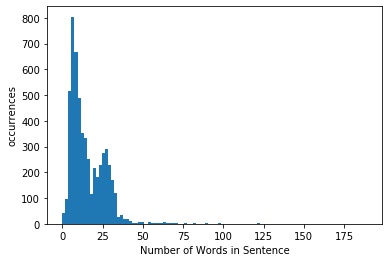

In [4]:
plt.hist([len(x_str) for x_str in X_str], bins=100)
plt.ylabel('occurrences')
plt.xlabel('Number of Words in Sentence')
plt.show()

MAX_SEQUENCE_LENGTH = 32

### Tokenization
----
Use `keras.preprocessing.text.Tokenizer` to encode each word into integer-based code according to word occurrences.

> **Your task**:  
> Adjust the argument `MAX_NUM_DICT_WORDS`, make sure the uncommon words (e.g., occurrences < 10) can be removed during the string-based to integer-based code conversion

In [0]:
MAX_NUM_DICT_WORDS = 1500

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NUM_DICT_WORDS, oov_token='UNK')
tokenizer.fit_on_texts(X_str)

In [6]:
def display_tokenizer_stat(tokenizer, max_items=None):
    list_tokenizer_stat_keys, list_tokenizer_stat_words, list_tokenizer_stat_cnts = [], [], []
    for key in sorted(tokenizer.index_word):
        word = tokenizer.index_word[key]
        cnt = -1
        if word != 'UNK':
            cnt = tokenizer.word_counts[word]
        list_tokenizer_stat_keys.append(key)
        list_tokenizer_stat_words.append(word)
        list_tokenizer_stat_cnts.append(cnt)

    df_tokenizer_stat = pd.DataFrame(columns=['Key', 'Word', 'Occurrences'],
                                     data={
                                         'Key': list_tokenizer_stat_keys,
                                         'Word': list_tokenizer_stat_words,
                                         'Occurrences': list_tokenizer_stat_cnts
                                     })
    if max_items is not None:
        display(df_tokenizer_stat[:max_items])
    else:
        display(df_tokenizer_stat)


# display here
display_tokenizer_stat(tokenizer, MAX_NUM_DICT_WORDS)

,Key,Word,Occurrences
0,1,UNK,-1
1,2,i,2361
2,3,to,2253
3,4,you,2154
4,5,a,1447
...,...,...,...
1495,1496,happens,7
1496,1497,behind,7
1497,1498,feb,7
1498,1499,planned,7


Now, use the pre-trained tokenizer to convert **string-based** sequences into **integer-based** sequence:

In [7]:
X = tokenizer.texts_to_sequences(X_str)
for x in X[:20]:
    print('[{}]'.format(', '.join([str(x_) for x_ in x])))

[50, 472, 1, 843, 756, 659, 65, 9, 1328, 89, 124, 352, 1329, 149, 1, 1330, 68, 59, 1, 145]
[47, 337, 1, 473, 7, 1]
[48, 490, 9, 20, 5, 798, 902, 3, 177, 1, 1106, 660, 1, 1, 262, 1, 72, 1, 3, 1, 3, 338, 490, 556, 961, 74, 392, 175, 661, 393, 1]
[7, 249, 151, 24, 383, 1, 7, 140, 155, 58, 151]
[1025, 2, 99, 109, 70, 491, 3, 962, 70, 1, 222, 113, 474]
[799, 130, 68, 1, 146, 110, 159, 1, 22, 8, 39, 339, 90, 903, 56, 117, 415, 4, 45, 13, 15, 87, 1, 47, 366, 961, 1, 3, 69, 324, 233, 3, 1]
[211, 12, 634, 10, 26, 56, 3, 384, 37, 11, 111, 719, 11, 56, 1, 1]
[73, 236, 14, 1205, 1, 1, 1, 1, 1, 1, 800, 119, 110, 610, 73, 14, 1026, 13, 52, 1, 844, 394, 3, 1107, 14, 250, 1026]
[720, 73, 5, 845, 442, 237, 4, 18, 110, 443, 3, 1, 1331, 152, 963, 3, 128, 17, 1, 128, 416, 1, 517, 964, 582, 65]
[137, 14, 98, 687, 1027, 27, 134, 7, 83, 1206, 3, 492, 3, 6, 325, 536, 904, 37, 340, 13, 48, 17, 6, 98, 492, 244, 48, 19, 1]
[31, 238, 36, 81, 223, 8, 2, 99, 71, 3, 289, 82, 41, 290, 1207, 227, 96, 209, 1, 444, 91]


### Sequences Padding
----
Most of deep learning framework working relies on batch processing. A fix-sized sequences dataset are definitely helpful for this. Therefore, we use sequence padding help function `tf.keras.preprocessing.sequence.pad_sequences` to convert variable-length sequences into fixed-length sequences.

> **Your task**:  
> Use `tf.keras.preprocessing.sequence.pad_sequences`, padding or truncating the sequences `X` into fixed-length array. Your length should be `MAX_SEQUENCE_LENGTH`.
> 
> Reference: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

In [8]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

for i in range(0, 10):
    print('{}'.format(X[i]))

[  50  472    1  843  756  659   65    9 1328   89  124  352 1329  149
    1 1330   68   59    1  145    0    0    0    0    0    0    0    0
    0    0    0    0]
[ 47 337   1 473   7   1   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  48  490    9   20    5  798  902    3  177    1 1106  660    1    1
  262    1   72    1    3    1    3  338  490  556  961   74  392  175
  661  393    1    0]
[  7 249 151  24 383   1   7 140 155  58 151   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[1025    2   99  109   70  491    3  962   70    1  222  113  474    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
[799 130  68   1 146 110 159   1  22   8  39 339  90 903  56 117 415   4
  45  13  15  87   1  47 366 961   1   3  69 324 233   3]
[211  12 634  10  26  56   3 384  37  11 111 719  11  56   1   1   0   0
   0   0   0   0   0   0   0   0   0   0  

### Label Encoder
----
Use `sklearn.preprocessing.LabelEncoder` to convert **string-based** label into **integer-based** label

In [9]:
label_encoder = LabelEncoder()
label_encoder.fit(df['label'])

Y = label_encoder.transform(df['label'])

display( [ (idx, label) for idx, label in enumerate(label_encoder.classes_) ] )

[(0, 'ham'), (1, 'spam')]

Now you already have cleaned, and good shaped data. Split it into training and testing set for further evaluation.

- **Training Set**  
    A set of examples used for learning the model parameters (i.e., weights or bases) of the classifier.

    The pair of data and corresponded label are expressed as variable (`X_train`, `Y_train`)
- **Testing Set**  
    A set of examples used for performance evaluation only.

    The pair of data and corresponded label are expressed as variable (`X_test`, `Y_test`)

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=0)

## Lab 2. Long Short-Term Memory (LSTM) - Spam Message Classification
----
Remember the following arguments:
- `MAX_NUM_DICT_WORDS`:  
    All possible words which may be appeared in the sentence dataset, which convert the word to the one-hot encoded space. The argument is used by tokenizer and embedding layer.
    
    If the word occurrence is less than the last item kept in the tokenizer, the word will be removed and replaced by `UNK`.
- `MAX_SEQUENCE_LENGTH`:  
    The maximum length of the sequences.
- `WORD_EMBED_DIMENSION`:  
    The dimension of the projected space of embedding layer.
    
Now, we use **LSTM** and **Embedding** layer to construct the sequence classifier.

For more details, please refer to **week5.pptx**.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 256)           384000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                82176     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 470,466
Trainable params: 470,466
Non-trainable params: 0
_________________________________________________________________


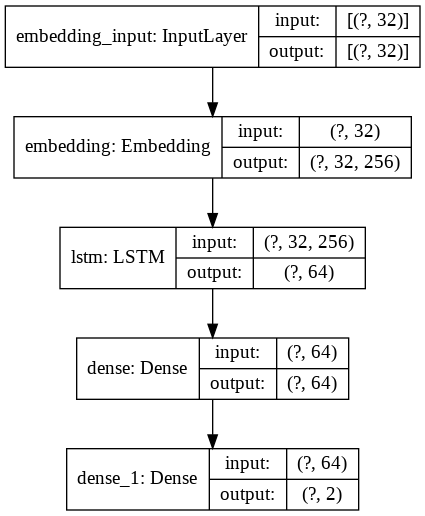

In [11]:
WORD_EMBED_DIMENSION = 256

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(MAX_NUM_DICT_WORDS, WORD_EMBED_DIMENSION, input_length=MAX_SEQUENCE_LENGTH),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)

In [12]:
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test), batch_size=64, shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 4736 samples, validate on 836 samples
Epoch 1/10
4736/4736 [==============================] - 6s 1ms/sample - loss: 0.2393 - acc: 0.9147 - val_loss: 0.0685 - val_acc: 0.9761
Epoch 2/10
4736/4736 [==============================] - 4s 924us/sample - loss: 0.0447 - acc: 0.9859 - val_loss: 0.0505 - val_acc: 0.9833
Epoch 3/10
4736/4736 [==============================] - 4s 934us/sample - loss: 0.0230 - acc: 0.9926 - val_loss: 0.0337 - val_acc: 0.9940
Epoch 4/10
4736/4736 [==============================] - 4s 934us/sample - loss: 0.0170 - acc: 0.9951 - val_loss: 0.0507 - val_acc: 0.9916
Epoch 5/10
4736/4736 [==============================] - 4s 915us/sample - loss: 0.0183 - acc: 0.9970 - val_loss: 0.0634 - val_acc: 0.9880
Epoch 6/10
4736/4736 [==============================] - 4s 921us/sample - loss: 0.0168 - acc: 0.9947 - val_loss: 0.0545 - val_acc: 0.9868
Epoch 7/10
4736/4736 [===========

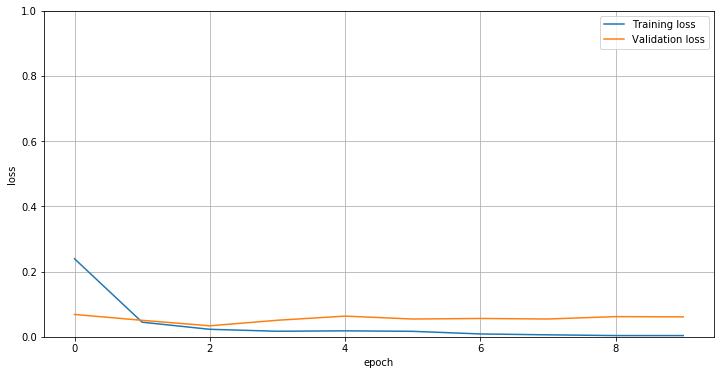

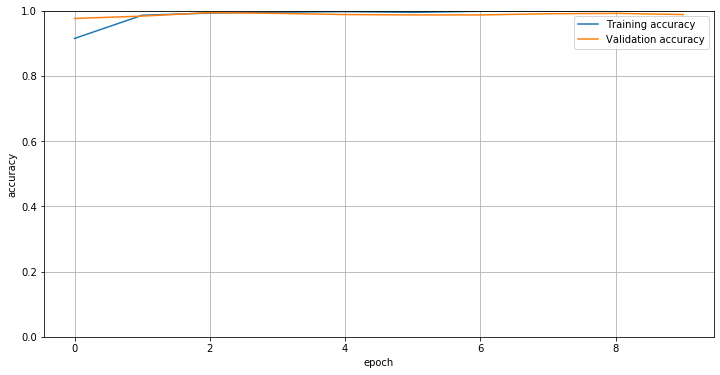

In [13]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.grid()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim((0.0, 1.0))
plt.show()

plt.figure(figsize=(12,6))
plt.plot(history.history['acc'], label='Training accuracy')
plt.plot(history.history['val_acc'], label='Validation accuracy')
plt.legend()
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0.0, 1.0))
plt.show()

## Lab 3. Sequence-to-Sequence Autoencoder - English to French Translation
----

### Dataset Preparation
----
The **Tatoeba** is a collection of sentences and translations. The subset `fra-eng` contains 160872 english to french sentence pair. Here, we use the first 10000 sentences for sequence to sequence autoencoder training and prediction.

For more information, please refer to:
- https://tatoeba.org/eng
- http://www.manythings.org/anki/

In [14]:
dataset_fra_eng_path = os.path.join(dataset_dir, 'fra.txt')

def download_fra_eng_dataset():
    if not os.path.exists('data/fra.txt'):
        if not os.path.exists('~/kaggle.json'):
            !mkdir ~/.kaggle
            !cp kaggle.json ~/.kaggle/
            !chmod 600 ~/.kaggle/kaggle.json
        !kaggle datasets download -d myksust/fra-eng
        !unzip fra-eng.zip
        !rm _about.txt
        !rm fra-eng.zip
        !mv fra.txt ./data

def prepare_fra_eng_dataset():
    with open(dataset_fra_eng_path, 'r', encoding='utf-8') as f:
        lines = f.read().split('\n')
    
    encoder_input_data_str, decoder_input_data_str, decoder_output_data_str = [], [], []
    
    max_len_src = 0
    max_len_tgt = 0
    for idx, line in enumerate(lines):
        if len(line) == 0:
            continue
        if idx == 10000:
            break
        source, target = line.split('\t')

        encoder_input_data_str.append(source)
        decoder_input_data_str.append('\t' + target)
        decoder_output_data_str.append(target + '\n')
        
    return encoder_input_data_str, decoder_input_data_str, decoder_output_data_str
        
download_fra_eng_dataset()
encoder_input_data_str, decoder_input_data_str, decoder_output_data_str = prepare_fra_eng_dataset()

  0% 0.00/3.20M [00:00<?, ?B/s]
100% 3.20M/3.20M [00:00<00:00, 104MB/s]
Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


In [15]:
df_eng_fra = pd.DataFrame({'English': encoder_input_data_str[:50],
                           'French (input)': decoder_input_data_str[:50],
                           'French (outputs)': decoder_output_data_str[:50]})
display(df_eng_fra)

,English,French (input),French (outputs)
0,Go.,\tVa !,Va !\n
1,Hi.,\tSalut !,Salut !\n
2,Run!,\tCours !,Cours !\n
3,Run!,\tCourez !,Courez !\n
4,Wow!,\tÇa alors !,Ça alors !\n
5,Fire!,\tAu feu !,Au feu !\n
6,Help!,\tÀ l'aide !,À l'aide !\n
7,Jump.,\tSaute.,Saute.\n
8,Stop!,\tÇa suffit !,Ça suffit !\n
9,Stop!,\tStop !,Stop !\n


> **Your task**:  
> In the function `prepare_fra_eng_dataset`, both English sentences (source) and French sentences (target) have been splited into word sequences. Please adjust the argument `MAX_SEQUENCE_LENGTH` based on the observation of the sequence length histogram.

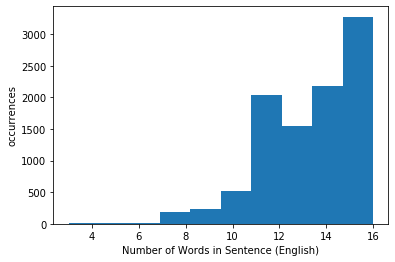

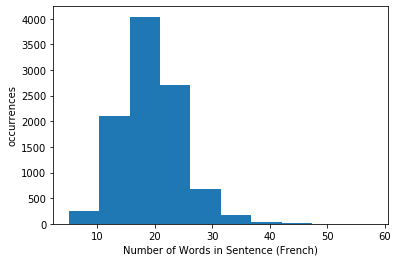

In [16]:
plt.hist([len(x_str) for x_str in encoder_input_data_str], bins=10)
plt.ylabel('occurrences')
plt.xlabel('Number of Words in Sentence (English)')
plt.show()

plt.hist([len(x_str) for x_str in decoder_output_data_str], bins=10)
plt.ylabel('occurrences')
plt.xlabel('Number of Words in Sentence (French)')
plt.show()

MAX_SEQUENCE_LENGTH_ENG = 16
MAX_SEQUENCE_LENGTH_FRA = 32

### Tokenization
----
Use `keras.preprocessing.text.Tokenizer` to encode each word into integer-based code according to word occurrences.

**Notice:** Due to scale of the dataset is relatively small, we use **Character-based** tokenization

> **Your task**:  
> Adjust the argument `MAX_NUM_DICT_TOKENS_ENG` and `MAX_NUM_DICT_TOKENS_FRA` for both english and french, make sure the uncommon words (e.g., occurrences < 10) can be removed during the string-based to integer-based code conversion

In [17]:
MAX_NUM_DICT_TOKENS_ENG = 45
MAX_NUM_DICT_TOKENS_FRA = 66


# English part
tokenizer_eng = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NUM_DICT_TOKENS_ENG, char_level=True)
tokenizer_eng.fit_on_texts(encoder_input_data_str)

encoder_input_data = tokenizer_eng.texts_to_sequences(encoder_input_data_str)
display_tokenizer_stat(tokenizer_eng, MAX_NUM_DICT_TOKENS_ENG)


# French part
tokenizer_fra = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NUM_DICT_TOKENS_FRA, char_level=True)
tokenizer_fra.fit_on_texts([sentence + '\n' for sentence in decoder_input_data_str])

decoder_input_data = tokenizer_fra.texts_to_sequences(decoder_input_data_str)
decoder_output_data = tokenizer_fra.texts_to_sequences(decoder_output_data_str)
display_tokenizer_stat(tokenizer_fra, MAX_NUM_DICT_TOKENS_FRA)

,Key,Word,Occurrences
0,1,,18616
1,2,e,13005
2,3,i,9009
3,4,o,8501
4,5,t,8482
5,6,.,8273
6,7,a,7116
7,8,s,6422
8,9,r,5140
9,10,n,4847


,Key,Word,Occurrences
0,1,,24395
1,2,e,21115
2,3,s,14856
3,4,i,11088
4,5,a,10454
...,...,...,...
61,62,(,1
62,63,),1
63,64,$,1
64,65,ë,1


### Sequences Padding
----
> **Your task**:  
> For the following integer-based sequences:
> - encoder_input_data
> - decoder_input_data
> - decoder_output_data
> 
> Use the function `tf.keras.preprocessing.sequence.pad_sequences` to convert variable-length sequences into fixed-length sequences. Remember that the maximum length should be `MAX_SEQUENCE_LENGTH`.

In [0]:
encoder_input_data = tf.keras.preprocessing.sequence.pad_sequences(encoder_input_data,
                                                                   maxlen=MAX_SEQUENCE_LENGTH_ENG,
                                                                   padding='post',
                                                                   truncating='post')
encoder_input_data = tf.keras.utils.to_categorical(encoder_input_data)

decoder_input_data = tf.keras.preprocessing.sequence.pad_sequences(decoder_input_data,
                                                                   maxlen=MAX_SEQUENCE_LENGTH_FRA,
                                                                   padding='post',
                                                                   truncating='post')
decoder_input_data = tf.keras.utils.to_categorical(decoder_input_data)


decoder_output_data = tf.keras.preprocessing.sequence.pad_sequences(decoder_output_data,
                                                                    maxlen=MAX_SEQUENCE_LENGTH_FRA,
                                                                    padding='post',
                                                                    truncating='post')
decoder_output_data = tf.keras.utils.to_categorical(decoder_output_data)

### Sequence to Sequence Autoencoder Model
----
Please refer to **week5.pptx** for more details

#### Create Model and Training
----

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None, 45)]   0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None, 66)]   0                                            
__________________________________________________________________________________________________
encoder_lstm (CuDNNLSTM)        [(None, 256), (None, 310272      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_lstm (CuDNNLSTM)        [(None, None, 256),  331776      decoder_input[0][0]              
                                                                 encoder_lstm[0][1]           

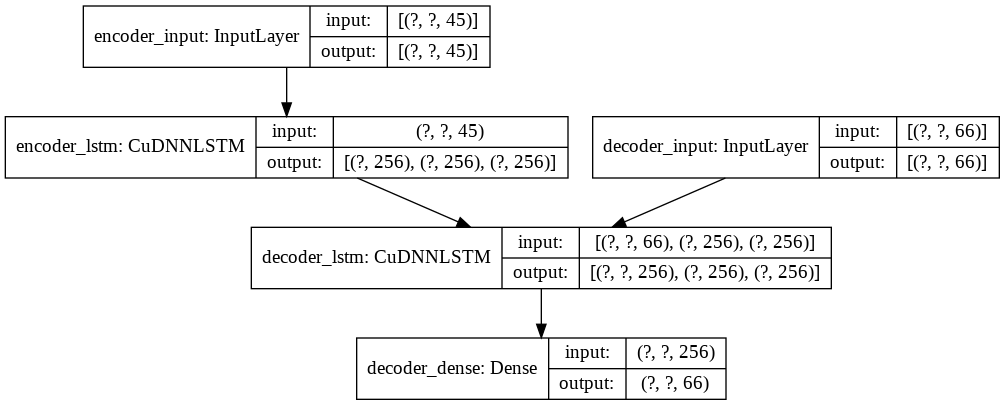

In [19]:
LSTM_LATENT_DIMENSION = 256


# ENCODER
encoder_input = tf.keras.layers.Input(shape=(None, MAX_NUM_DICT_TOKENS_ENG),
                                      name='encoder_input')
encoder_lstm = tf.keras.layers.CuDNNLSTM(LSTM_LATENT_DIMENSION,
                                    return_state=True,
                                    name='encoder_lstm')
encoder_outputs, state_h, state_c = encoder_lstm (encoder_input)
encoder_states = [state_h, state_c]


# DECODER
decoder_input = tf.keras.layers.Input(shape=(None, MAX_NUM_DICT_TOKENS_FRA),
                                      name='decoder_input')
decoder_lstm = tf.keras.layers.CuDNNLSTM(LSTM_LATENT_DIMENSION,
                                    return_sequences=True,
                                    return_state=True,
                                    name='decoder_lstm')
decoder_lstm_out, _, _ = decoder_lstm(decoder_input,
                                      initial_state=encoder_states)
decoder_dense = tf.keras.layers.Dense(MAX_NUM_DICT_TOKENS_FRA,
                                      activation='softmax',
                                      name='decoder_dense')
decoder_outputs = decoder_dense (decoder_lstm_out)


# MODEL
model = tf.keras.models.Model([encoder_input, decoder_input], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)

In [20]:
history = model.fit([encoder_input_data, decoder_input_data],
                    decoder_output_data,
                    batch_size=64,
                    epochs=100,
                    validation_split=0.1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 15s 2ms/sample - loss: 1.9791 - acc: 0.4854 - val_loss: 2.2061 - val_acc: 0.4481
Epoch 2/100
9000/9000 [==============================] - 2s 184us/sample - loss: 1.3932 - acc: 0.6114 - val_loss: 1.4622 - val_acc: 0.5758
Epoch 3/100
9000/9000 [==============================] - 2s 182us/sample - loss: 1.1368 - acc: 0.6683 - val_loss: 1.2692 - val_acc: 0.6239
Epoch 4/100
9000/9000 [==============================] - 2s 188us/sample - loss: 1.0233 - acc: 0.6996 - val_loss: 1.1946 - val_acc: 0.6475
Epoch 5/100
9000/9000 [==============================] - 2s 181us/sample - loss: 0.9438 - acc: 0.7223 - val_loss: 1.0899 - val_acc: 0.6790
Epoch 6/100
9000/9000 [==============================] - 2s 180us/sample - loss: 0.8812 - acc: 0.7382 - val_loss: 1.0650 - val_acc: 0.6843
Epoch 7/100
9000/9000 [==============================] - 2s 183us/sample - loss: 0.8311 - acc: 0.7520 - val_loss: 1.026

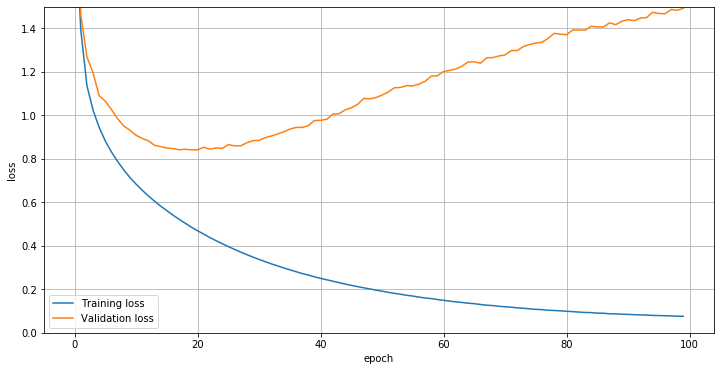

In [21]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.grid()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim((0.0, 1.5))
plt.show()

#### Predict Sentence by Pre-trained Sequence to Sequence Model
----

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      [(None, None, 66)]   0                                            
__________________________________________________________________________________________________
decoder_state_input_h (InputLay [(None, 256)]        0                                            
__________________________________________________________________________________________________
decoder_state_input_c (InputLay [(None, 256)]        0                                            
__________________________________________________________________________________________________
decoder_lstm (CuDNNLSTM)        [(None, None, 256),  331776      decoder_input[0][0]              
                                                                 decoder_state_input_h[0][0]

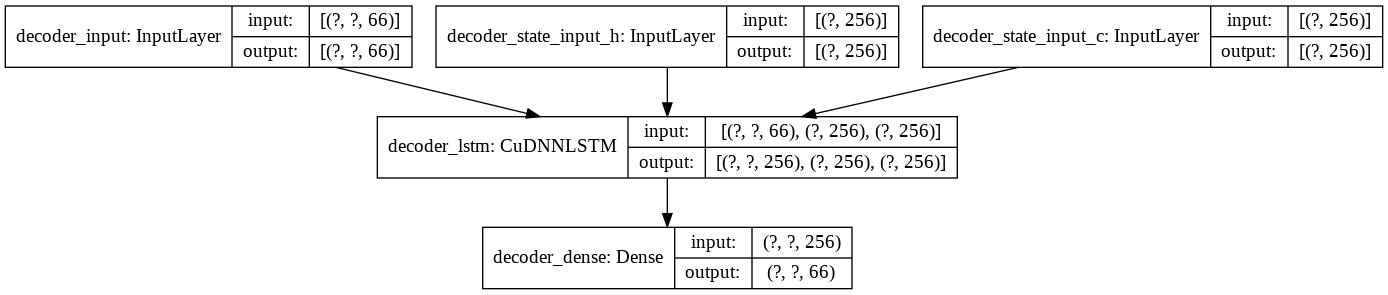

In [22]:
encoder_model = tf.keras.models.Model(encoder_input, encoder_states)

decoder_state_input_h = tf.keras.layers.Input(shape=(LSTM_LATENT_DIMENSION,),
                                              name='decoder_state_input_h')
decoder_state_input_c = tf.keras.layers.Input(shape=(LSTM_LATENT_DIMENSION,),
                                              name='decoder_state_input_c')
decoder_states_input = [decoder_state_input_h, decoder_state_input_c]

decoder_lstm_out, state_h, state_c = decoder_lstm(decoder_input, initial_state=decoder_states_input)
decoder_states = [state_h, state_c]
decoder_output = decoder_dense(decoder_lstm_out)

decoder_model = tf.keras.models.Model([decoder_input] + decoder_states_input,
                                      [decoder_output] + decoder_states)
decoder_model.summary()

tf.keras.utils.plot_model(decoder_model, show_layer_names=True, show_shapes=True)

In [0]:
token_fra_start_idx = tokenizer_fra.texts_to_sequences([['\t']])[0][0]
token_fra_end_idx = tokenizer_fra.texts_to_sequences([['\n']])[0][0]

def decode_sequence(input_seq):
    # Get the states h and c from source language (English)
    states_value = encoder_model.predict(input_seq)

    # Sampling loop for a batch of sequences
    stop_condition = False
    
    # Decoded sentence - One-hot array
    decoded_sentence_onehot = np.zeros((1, 1, MAX_NUM_DICT_TOKENS_FRA))
    decoded_sentence_onehot[0, 0, token_fra_start_idx] = 1
    
    # Decoded sentence - Integer code-based sequence
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([decoded_sentence_onehot] + states_value)

        # Sample a token
        token_idx = np.argmax(output_tokens[0, -1, :])
        decoded_sentence += tokenizer_fra.index_word[token_idx]

        # Exit condition: either hit max length
        # or find stop character.
        if (token_idx == token_fra_end_idx or len(decoded_sentence) >= MAX_SEQUENCE_LENGTH_FRA):
            stop_condition = True

        # Update the target sequence (of length 1).
        decoded_sentence_onehot = np.zeros((1, 1, MAX_NUM_DICT_TOKENS_FRA))
        decoded_sentence_onehot[0, 0, token_idx] = 1

        # Update states
        states_value = [h, c]
    
    # Decoded sentence - Integer code-based sequence to Character-based sequence
    return decoded_sentence


In [24]:
decoder_output_data_str_predicted = []
for i in range(0, 50):
    decoder_output_data_str_predicted.append(decode_sequence(encoder_input_data[i:i+1, :]))

df_eng_fra_predict = pd.DataFrame({'English': encoder_input_data_str[:50],
                                   'French (Actual)': decoder_input_data_str[:50],
                                   'French (Predict)': decoder_output_data_str_predicted[:50]})
display(df_eng_fra_predict)

,English,French (Actual),French (Predict)
0,Go.,\tVa !,va !\n
1,Hi.,\tSalut !,salut !\n
2,Run!,\tCours !,courez !\n
3,Run!,\tCourez !,courez !\n
4,Wow!,\tÇa alors !,ça alors !\n
5,Fire!,\tAu feu !,au feu !\n
6,Help!,\tÀ l'aide !,à l'aide !\n
7,Jump.,\tSaute.,saute.\n
8,Stop!,\tÇa suffit !,arrête-toi !\n
9,Stop!,\tStop !,arrête-toi !\n



**Once finished, please Submit Your Colab Notebook [Here](https://forms.gle/2VZkhTyH59hZhD249)**

----

**NOTICE:** It takes time to train a sequence to sequence autoencoder. For your convenience:
- Both Lab1 and Lab2 are required
- Lab3 is optional